In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate, LayerNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error
from math import sqrt

In [ ]:
# Load and Prepare Normalized Data
FILE_PATH = "Book5.xlsx"  # Update if needed
df = pd.read_excel(FILE_PATH)
data = df[['CURRENT', 'VOLTAGE','TEMP','ohm.R','OCV','docv/dt','di/dt','dv/dt','Va ','Vb', 'C-rate current', 'energy loss', 'SOC']].dropna()

# ✅ Function to create sequences
def create_sequences(df, seq_len):
    X, y = [], []
    for i in range(len(df) - seq_len):
        X.append(df.iloc[i:i+seq_len][['CURRENT', 'VOLTAGE','TEMP','ohm.R','OCV','docv/dt','di/dt','dv/dt','Va ','Vb', 'C-rate current', 'energy loss']].values)
        y.append(df.iloc[i+seq_len]['SOC'])
    return np.array(X), np.array(y)

SEQ_LEN = 30  # Tuned for better performance
X, y = create_sequences(data, SEQ_LEN)

In [ ]:
# Define Attention-LSTM Model (unchanged architecture)
class AttentionLSTMSOC:
    def __init__(self, seq_len=30):
        self.seq_len = seq_len
        self.model = None

    def attention_block(self, inputs):
        query = Dense(64)(inputs)
        key = Dense(64)(inputs)
        value = Dense(64)(inputs)
        attention_output = Attention(use_scale=True)([query, key, value])
        combined = Concatenate()([inputs, attention_output])
        return combined

    def build_model(self):
        input_layer = Input(shape=(self.seq_len, 12))
        x = self.attention_block(input_layer)
        x = LayerNormalization()(x)
        x = LSTM(128, return_sequences=True)(x)
        x = Dropout(0.4)(x)
        x = LSTM(64)(x)
        x = Dense(32, activation='relu')(x)
        output = Dense(1)(x)
        self.model = Model(inputs=input_layer, outputs=output)
        return self.model

    def compile_model(self):
        self.model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                           loss='mse',
                           metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])

    def train(self, X, y, save_dir, batch_size=64, epochs=500):
        os.makedirs(save_dir, exist_ok=True)
        callbacks = [
            ModelCheckpoint(os.path.join(save_dir, 'best_model.keras'),
                            save_best_only=True, monitor='val_rmse', mode='min', verbose=1),
            EarlyStopping(monitor='val_rmse', mode='min', patience=50,
                          restore_best_weights=True, verbose=1),
            ReduceLROnPlateau(monitor='val_rmse', mode='min', factor=0.2,
                              patience=20, verbose=1)
        ]
        return self.model.fit(
            X, y,
            validation_split=0.05,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )

In [ ]:
# Train the Model
SAVE_DIR = "./soc_model_checkpoints"
attn = AttentionLSTMSOC(seq_len=SEQ_LEN)
model = attn.build_model()
attn.compile_model()

start = time.time()
history = attn.train(X, y, SAVE_DIR, batch_size=64, epochs=500)
print(f"\n⏱ Total training time: {(time.time() - start) / 60:.2f} minutes")

Epoch 1/500
505/507 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0145 - rmse: 0.1042
Epoch 1: val_rmse improved from inf to 0.02438, saving model to ./soc_model_checkpoints/best_model.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.0144 - rmse: 0.1040 - val_loss: 5.9432e-04 - val_rmse: 0.0244 - learning_rate: 0.0010
Epoch 2/500
506/507 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.2510e-04 - rmse: 0.0180
Epoch 2: val_rmse improved from 0.02438 to 0.01470, saving model to ./soc_model_checkpoints/best_model.keras
507/507 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.2500e-04 - rmse: 0.0180 - val_loss: 2.1596e-04 - val_rmse: 0.0147 - learning_rate: 0.0010
Epoch 3/500
507/507 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.1196e-04 - rmse: 0.0145
Epoch 3: val_rmse did not improve from 0.01470
507/507 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 2.1189e-04 - rmse: 0.0145 - val_loss: 3.3839e-04 - val_rmse: 0.0184 - learning_rate: 0.0010
Epoch 4/500
503/507 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

1068/1068 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


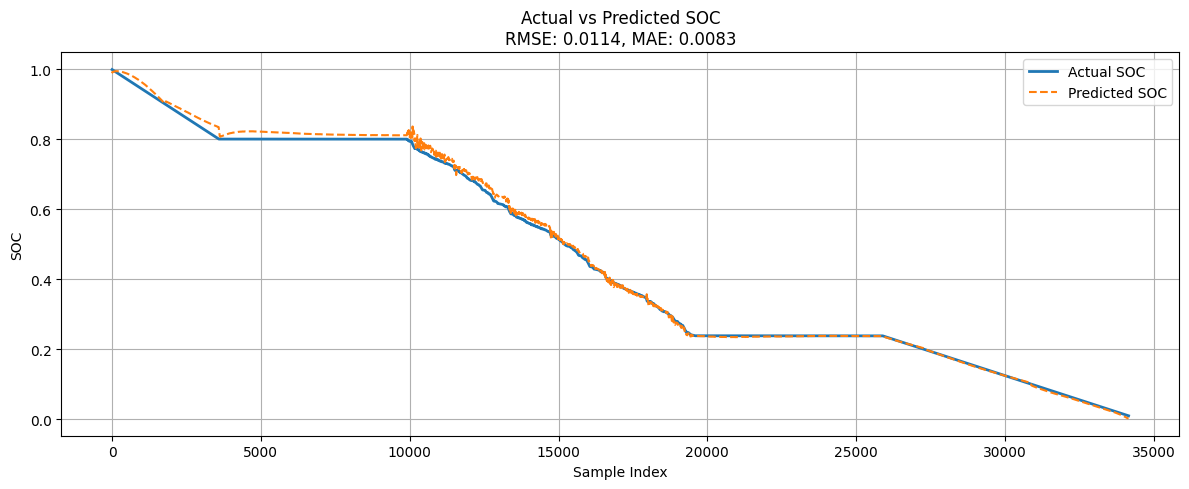

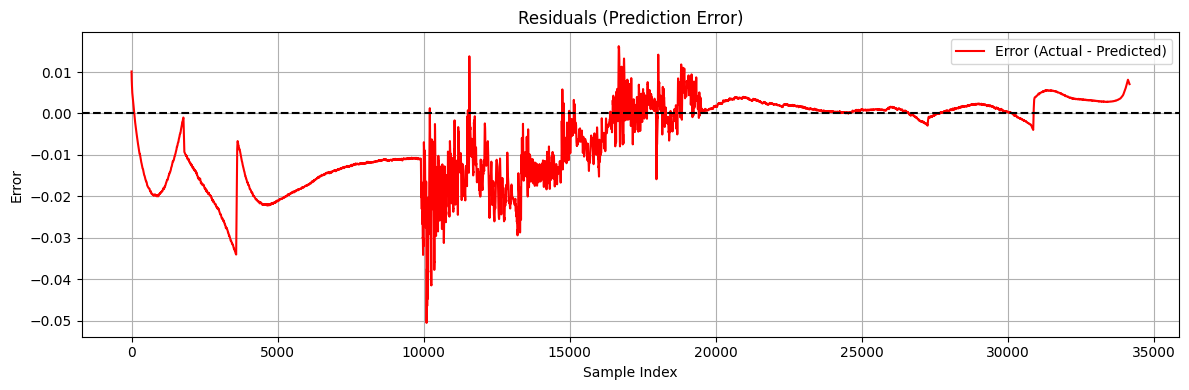

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Predict SOC from input
y_pred = attn.model.predict(X).flatten()  # Flatten to 1D

#Compute error metrics
errors = y - y_pred
rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)

#  Actual vs Predicted Plot
plt.figure(figsize=(12, 5))
plt.plot(y, label='Actual SOC', linewidth=2)
plt.plot(y_pred, label='Predicted SOC', linestyle='--')
plt.title(f'Actual vs Predicted SOC\nRMSE: {rmse:.4f}, MAE: {mae:.4f}')
plt.xlabel('Sample Index')
plt.ylabel('SOC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Residuals (Errors)
plt.figure(figsize=(12, 4))
plt.plot(errors, color='red', label='Error (Actual - Predicted)')
plt.axhline(0, linestyle='--', color='black')
plt.title('Residuals (Prediction Error)')
plt.xlabel('Sample Index')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

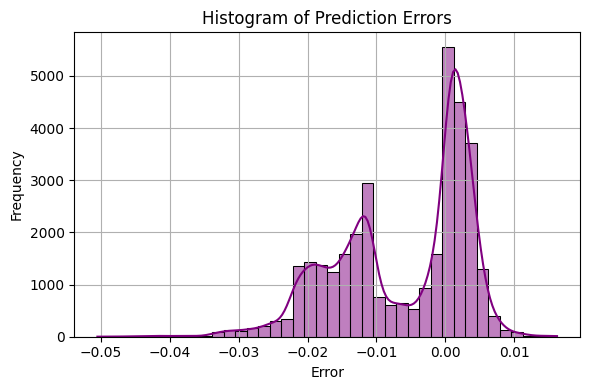

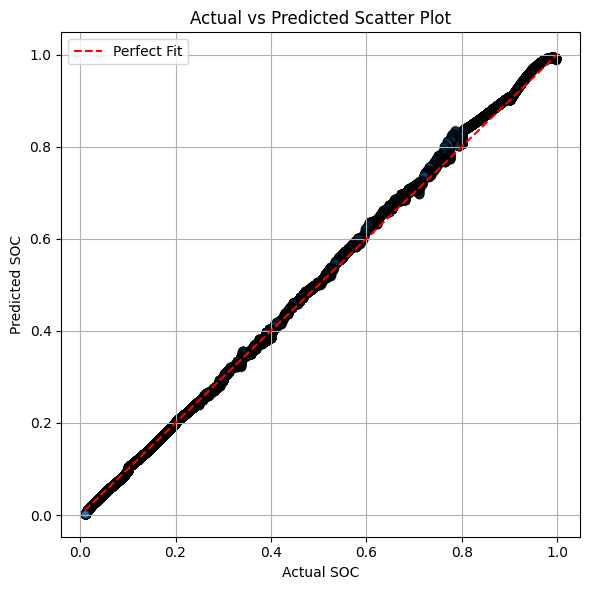

In [ ]:
# Histogram of Errors
plt.figure(figsize=(6, 4))
sns.histplot(errors, bins=40, kde=True, color='purple')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred, alpha=0.5, edgecolor='k')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Perfect Fit')
plt.xlabel('Actual SOC')
plt.ylabel('Predicted SOC')
plt.title('Actual vs Predicted Scatter Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🎯 STARTING TRUE SHAP EXPLAINABLE AI ANALYSIS WITH EXCEL EXPORT
✅ SHAP-compatible model wrapper created

🧠 Running SHAP Analysis (this may take a few minutes)...
🎯 STARTING COMPLETE SHAP ANALYSIS
This is TRUE Explainable AI using SHAP values!
Preparing data for SHAP analysis...
Background samples: (50, 30, 12)
Samples to explain: (100, 30, 12)
Creating SHAP Sampling Explainer (for complex neural networks)...
✅ SHAP Sampling Explainer created successfully!
Generating SHAP values using sampling method...


  0%|          | 0/100 [00:00<?, ?it/s]

✅ SHAP values generated! Shape: (100, 360)

🧠 SHAP ANALYSIS RESULTS
🎯 FEATURE IMPORTANCE FROM SHAP:
----------------------------------------
  OCV            :  45.2% contribution
  VOLTAGE        :  36.7% contribution
  C-rate current :   4.4% contribution
  Va             :   4.1% contribution
  docv/dt        :   2.9% contribution
  Vb             :   2.2% contribution
  CURRENT        :   1.7% contribution
  energy loss    :   1.4% contribution
  TEMP           :   0.5% contribution
  dv/dt          :   0.4% contribution
  di/dt          :   0.3% contribution
  ohm.R          :   0.1% contribution
📊 Exporting SHAP values to Excel: SOC_SHAP_Analysis.xlsx
✅ Excel file created successfully: SOC_SHAP_Analysis.xlsx
📋 Sheets created:
   - Feature_Importance: Overall feature ranking and contribution
   - Raw_SHAP_Values: All SHAP values (flattened)
   - SHAP_Avg_Over_Time: SHAP values averaged across time steps
   - SHAP_Latest_Timestep: SHAP values for the latest time step
   - Feature_V

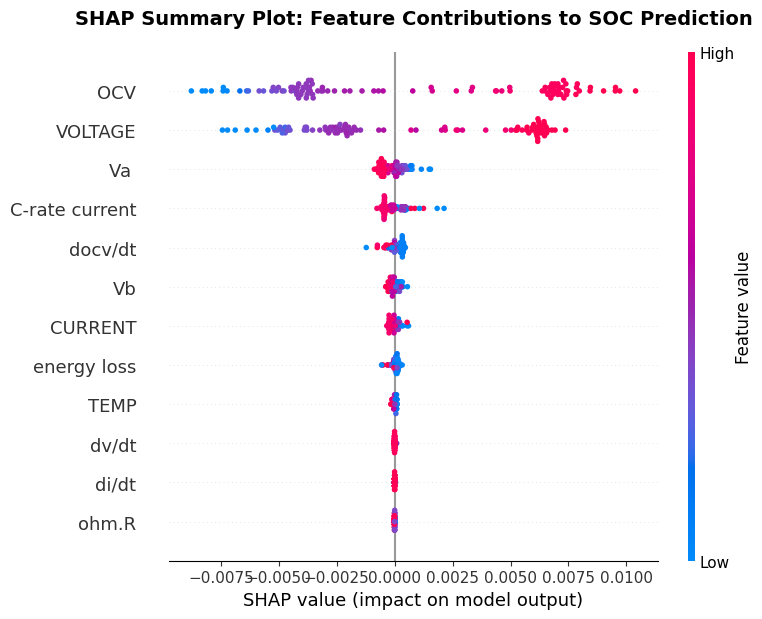

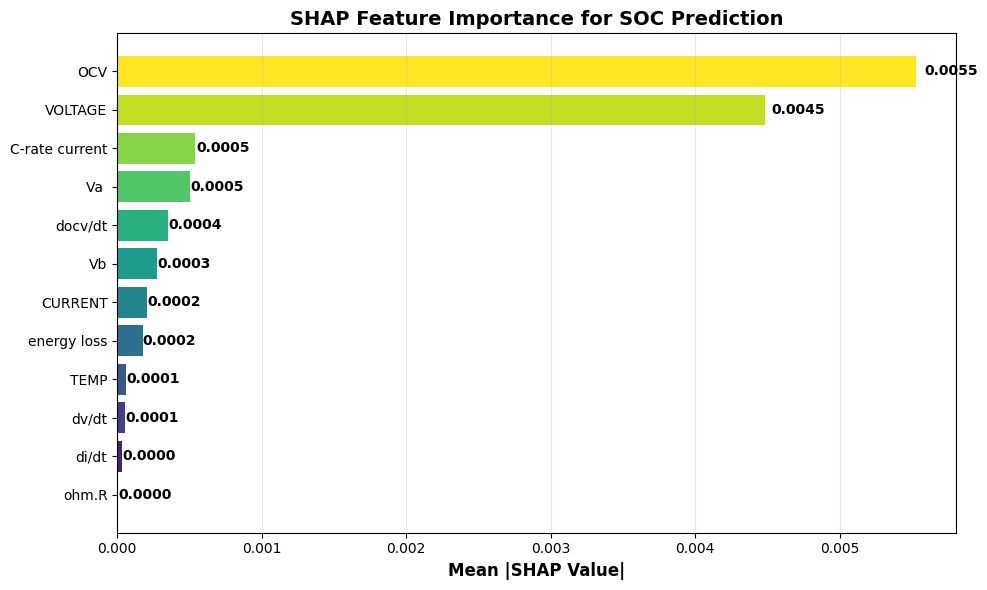


✅ SHAP ANALYSIS COMPLETE!
This shows HOW MUCH each feature contributes to individual predictions
Unlike correlation, SHAP shows actual model decision-making process
📊 SHAP values exported to: SOC_SHAP_Analysis.xlsx

📊 FINAL SHAP RESULTS:
This shows the TRUE contribution of each feature to SOC predictions
(Not just correlation - but actual model decision importance)
  OCV            :  45.2% SHAP contribution
  VOLTAGE        :  36.7% SHAP contribution
  C-rate current :   4.4% SHAP contribution
  Va             :   4.1% SHAP contribution
  docv/dt        :   2.9% SHAP contribution
  Vb             :   2.2% SHAP contribution
  CURRENT        :   1.7% SHAP contribution
  energy loss    :   1.4% SHAP contribution
  TEMP           :   0.5% SHAP contribution
  dv/dt          :   0.4% SHAP contribution
  di/dt          :   0.3% SHAP contribution
  ohm.R          :   0.1% SHAP contribution

📁 Excel file saved as: SOC_SHAP_Analysis.xlsx
You can now open this file to explore SHAP values in det

In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import os

# Fix for SHAP + Keras compatibility
import tensorflow.keras.backend as K

class TrueSHAPExplainer:
    def __init__(self, model_path, feature_names=None):
        """Proper SHAP implementation for LSTM models"""
        self.model = load_model(model_path)
        self.feature_names = feature_names or [
            'CURRENT', 'VOLTAGE','TEMP','ohm.R','OCV','docv/dt','di/dt','dv/dt','Va ','Vb', 'C-rate current', 'energy loss'
        ]

        # Create a wrapper function for SHAP compatibility
        self.model_predict = self._create_prediction_wrapper()
        self.shap_values = None
        self.X_explain_data = None  # Store original data for Excel export
        print("✅ SHAP-compatible model wrapper created")

    def _create_prediction_wrapper(self):
        """Create prediction wrapper that SHAP can handle"""
        def predict_wrapper(X):
            # Ensure input is the right shape and type
            if len(X.shape) == 2:
                # If 2D, assume it's flattened - reshape to 3D
                X = X.reshape(X.shape[0], 30, 12)  # Your sequence length and features

            # Convert to float32 tensor
            X_tensor = tf.cast(X, tf.float32)

            # Get predictions
            predictions = self.model(X_tensor, training=False)
            return predictions.numpy()

        return predict_wrapper

    def prepare_data_for_shap(self, X_data, max_background=50, max_explain=100):
        """Prepare data in format SHAP can handle"""
        print(f"Preparing data for SHAP analysis...")

        # Background data (for SHAP baseline)
        background_indices = np.random.choice(len(X_data), min(max_background, len(X_data)), replace=False)
        X_background = X_data[background_indices]

        # Data to explain
        explain_indices = np.random.choice(len(X_data), min(max_explain, len(X_data)), replace=False)
        X_explain = X_data[explain_indices]

        # Store original data for Excel export
        self.X_explain_data = X_explain.copy()
        self.explain_indices = explain_indices

        print(f"Background samples: {X_background.shape}")
        print(f"Samples to explain: {X_explain.shape}")

        return X_background, X_explain

    def create_shap_explainer_v2(self, X_background):
        """Create SHAP explainer using Kernel method (model-agnostic)"""
        print("Creating SHAP Kernel Explainer (works with any model)...")

        # Flatten background data for KernelExplainer
        X_background_flat = X_background.reshape(X_background.shape[0], -1)

        # Create prediction function for flattened input
        def predict_flat(X_flat):
            X_3d = X_flat.reshape(X_flat.shape[0], 30, 12)
            return self.model_predict(X_3d).flatten()

        # Create SHAP Kernel explainer
        self.explainer = shap.KernelExplainer(predict_flat, X_background_flat)
        print("✅ SHAP Kernel Explainer created successfully!")

    def create_shap_explainer_v3(self, X_background):
        """Alternative: Use Sampling explainer for complex models"""
        print("Creating SHAP Sampling Explainer (for complex neural networks)...")

        # Flatten background data
        X_background_flat = X_background.reshape(X_background.shape[0], -1)

        def predict_for_shap(X_flat):
            if len(X_flat.shape) == 1:
                X_flat = X_flat.reshape(1, -1)
            X_3d = X_flat.reshape(X_flat.shape[0], 30, 12)
            predictions = self.model_predict(X_3d)
            return predictions.flatten()

        # Use Sampling explainer (faster than Kernel)
        self.explainer = shap.explainers.Sampling(predict_for_shap, X_background_flat)
        print(" SHAP Sampling Explainer created successfully!")

    def explain_with_shap(self, X_explain, method='sampling'):
        """Generate SHAP values"""
        print(f"Generating SHAP values using {method} method...")

        # Flatten explanation data
        X_explain_flat = X_explain.reshape(X_explain.shape[0], -1)

        try:
            # Generate SHAP values
            if method == 'sampling':
                shap_values = self.explainer(X_explain_flat)
                # Extract values (new SHAP format)
                if hasattr(shap_values, 'values'):
                    self.shap_values = shap_values.values
                else:
                    self.shap_values = shap_values
            else:  # kernel method
                self.shap_values = self.explainer.shap_values(X_explain_flat)

            print(f" SHAP values generated! Shape: {np.array(self.shap_values).shape}")
            return self.shap_values

        except Exception as e:
            print(f" Error generating SHAP values: {e}")
            return None

    def export_shap_to_excel(self, filename=None):
        """Export SHAP values to Excel file with multiple sheets"""
        if self.shap_values is None:
            print(" No SHAP values available. Generate them first!")
            return None

        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"SHAP_Analysis_{timestamp}.xlsx"

        print(f"📊 Exporting SHAP values to Excel: {filename}")

        try:
            # Reshape SHAP values back to time series format
            shap_3d = self.shap_values.reshape(self.shap_values.shape[0], 30, 12)

            # Create Excel writer object
            with pd.ExcelWriter(filename, engine='openpyxl') as writer:

                # Sheet 1: Feature Importance Summary
                feature_importance = np.mean(np.abs(shap_3d), axis=(0, 1))
                summary_df = pd.DataFrame({
                    'Feature': self.feature_names,
                    'Mean_Absolute_SHAP': feature_importance,
                    'Contribution_Percentage': (feature_importance / feature_importance.sum()) * 100,
                    'Rank': range(1, len(self.feature_names) + 1)
                }).sort_values('Mean_Absolute_SHAP', ascending=False)
                summary_df['Rank'] = range(1, len(summary_df) + 1)
                summary_df.to_excel(writer, sheet_name='Feature_Importance', index=False)

                # Sheet 2: Raw SHAP Values (Flattened - All time steps)
                shap_df = pd.DataFrame(
                    self.shap_values,
                    columns=[f'{feature}_t{t}' for t in range(30) for feature in self.feature_names]
                )
                shap_df.insert(0, 'Sample_ID', range(len(shap_df)))
                shap_df.to_excel(writer, sheet_name='Raw_SHAP_Values', index=False)

                # Sheet 3: SHAP Values Averaged Over Time
                shap_avg_time = np.mean(shap_3d, axis=1)
                shap_avg_df = pd.DataFrame(shap_avg_time, columns=self.feature_names)
                shap_avg_df.insert(0, 'Sample_ID', range(len(shap_avg_df)))
                shap_avg_df.to_excel(writer, sheet_name='SHAP_Avg_Over_Time', index=False)

                # Sheet 4: SHAP Values for Latest Time Step (t=29)
                shap_latest = shap_3d[:, -1, :]
                shap_latest_df = pd.DataFrame(shap_latest, columns=self.feature_names)
                shap_latest_df.insert(0, 'Sample_ID', range(len(shap_latest_df)))
                shap_latest_df.to_excel(writer, sheet_name='SHAP_Latest_Timestep', index=False)

                # Sheet 5: Feature Values (for reference)
                if hasattr(self, 'X_explain_data') and self.X_explain_data is not None:
                    # Use latest timestep feature values
                    feature_values = self.X_explain_data[:, -1, :]
                    feature_df = pd.DataFrame(feature_values, columns=self.feature_names)
                    feature_df.insert(0, 'Sample_ID', range(len(feature_df)))
                    feature_df.to_excel(writer, sheet_name='Feature_Values', index=False)

                # Sheet 6: SHAP Values by Time Steps (Sample-wise breakdown)
                # Create a comprehensive time series breakdown
                sample_breakdown_data = []
                for sample_idx in range(min(10, shap_3d.shape[0])):  # Limit to first 10 samples
                    for timestep in range(30):
                        row_data = {
                            'Sample_ID': sample_idx,
                            'Timestep': timestep,
                        }
                        for feat_idx, feature_name in enumerate(self.feature_names):
                            row_data[feature_name] = shap_3d[sample_idx, timestep, feat_idx]
                        sample_breakdown_data.append(row_data)

                sample_breakdown_df = pd.DataFrame(sample_breakdown_data)
                sample_breakdown_df.to_excel(writer, sheet_name='Time_Series_Breakdown', index=False)

                # Sheet 7: Statistical Summary
                stats_data = []
                for feat_idx, feature_name in enumerate(self.feature_names):
                    feature_shap_values = shap_3d[:, :, feat_idx].flatten()
                    stats_data.append({
                        'Feature': feature_name,
                        'Mean': np.mean(feature_shap_values),
                        'Std': np.std(feature_shap_values),
                        'Min': np.min(feature_shap_values),
                        'Max': np.max(feature_shap_values),
                        'Q25': np.percentile(feature_shap_values, 25),
                        'Q50': np.percentile(feature_shap_values, 50),
                        'Q75': np.percentile(feature_shap_values, 75),
                        'Mean_Absolute': np.mean(np.abs(feature_shap_values))
                    })

                stats_df = pd.DataFrame(stats_data)
                stats_df.to_excel(writer, sheet_name='Statistical_Summary', index=False)

            print(f"✅ Excel file created successfully: {filename}")
            print(f" Sheets created:")
            print("   - Feature_Importance: Overall feature ranking and contribution")
            print("   - Raw_SHAP_Values: All SHAP values (flattened)")
            print("   - SHAP_Avg_Over_Time: SHAP values averaged across time steps")
            print("   - SHAP_Latest_Timestep: SHAP values for the latest time step")
            print("   - Feature_Values: Original feature values for reference")
            print("   - Time_Series_Breakdown: Sample-wise time series breakdown")
            print("   - Statistical_Summary: Statistical analysis of SHAP values")

            return filename

        except Exception as e:
            print(f"❌ Error exporting to Excel: {e}")
            import traceback
            traceback.print_exc()
            return None

    def analyze_shap_results(self, X_explain):
        """Analyze and interpret SHAP results"""
        if self.shap_values is None:
            print("❌ No SHAP values available. Generate them first!")
            return None

        print(f"\n🧠 SHAP ANALYSIS RESULTS")
        print("="*50)

        # Reshape SHAP values back to time series format
        shap_3d = self.shap_values.reshape(self.shap_values.shape[0], 30, 12)

        # Calculate feature importance (average absolute SHAP across samples and time)
        feature_importance = np.mean(np.abs(shap_3d), axis=(0, 1))

        # Create results dataframe
        results_df = pd.DataFrame({
            'Feature': self.feature_names,
            'SHAP_Importance': feature_importance,
            'Contribution_Pct': (feature_importance / feature_importance.sum()) * 100
        }).sort_values('SHAP_Importance', ascending=False)

        print("🎯 FEATURE IMPORTANCE FROM SHAP:")
        print("-" * 40)
        for _, row in results_df.iterrows():
            print(f"  {row['Feature']:15s}: {row['Contribution_Pct']:5.1f}% contribution")

        return results_df

    def plot_shap_summary(self, X_explain):
        """Create SHAP summary plots"""
        if self.shap_values is None:
            print("❌ No SHAP values to plot!")
            return

        print("Creating SHAP visualizations...")

        # Reshape for plotting
        shap_3d = self.shap_values.reshape(self.shap_values.shape[0], 30, 12)

        # Average SHAP values across time dimension for summary plot
        shap_summary = np.mean(shap_3d, axis=1)

        # Feature values (use last time step)
        feature_values = X_explain[:, -1, :]

        plt.figure(figsize=(12, 8))

        # Create summary plot
        shap.summary_plot(
            shap_summary,
            feature_values,
            feature_names=self.feature_names,
            show=False
        )
        plt.title('SHAP Summary Plot: Feature Contributions to SOC Prediction',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()

    def plot_shap_bar(self):
        """Create SHAP bar plot"""
        if self.shap_values is None:
            return

        # Calculate mean absolute SHAP values
        shap_3d = self.shap_values.reshape(self.shap_values.shape[0], 30, 12)
        feature_importance = np.mean(np.abs(shap_3d), axis=(0, 1))

        plt.figure(figsize=(10, 6))

        # Sort features by importance
        sorted_idx = np.argsort(feature_importance)
        sorted_features = [self.feature_names[i] for i in sorted_idx]
        sorted_importance = feature_importance[sorted_idx]

        # Create bar plot
        colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_features)))
        bars = plt.barh(sorted_features, sorted_importance, color=colors)

        plt.xlabel('Mean |SHAP Value|', fontsize=12, fontweight='bold')
        plt.title('SHAP Feature Importance for SOC Prediction', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)

        # Add value labels
        for bar in bars:
            width = bar.get_width()
            plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                    f'{width:.4f}', ha='left', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def complete_shap_analysis(self, X_data, method='sampling', excel_filename=None):
        """Complete SHAP analysis pipeline with Excel export"""
        print("🎯 STARTING COMPLETE SHAP ANALYSIS")
        print("="*60)
        print("This is TRUE Explainable AI using SHAP values!")

        # Prepare data
        X_background, X_explain = self.prepare_data_for_shap(X_data)

        # Create explainer
        if method == 'sampling':
            self.create_shap_explainer_v3(X_background)
        else:
            self.create_shap_explainer_v2(X_background)

        # Generate SHAP values
        shap_values = self.explain_with_shap(X_explain, method)

        if shap_values is not None:
            # Analyze results
            results_df = self.analyze_shap_results(X_explain)

            # Export to Excel
            excel_file = self.export_shap_to_excel(excel_filename)

            # Create visualizations
            self.plot_shap_summary(X_explain)
            self.plot_shap_bar()

            print(f"\n✅ SHAP ANALYSIS COMPLETE!")
            print("This shows HOW MUCH each feature contributes to individual predictions")
            print("Unlike correlation, SHAP shows actual model decision-making process")

            if excel_file:
                print(f"📊 SHAP values exported to: {excel_file}")

            return results_df, excel_file
        else:
            print("❌ SHAP analysis failed. Falling back to alternative method...")
            return None, None

# Execute TRUE SHAP Analysis with Excel Export
print("🎯 STARTING TRUE SHAP EXPLAINABLE AI ANALYSIS WITH EXCEL EXPORT")
print("="*70)

try:
    # Initialize SHAP explainer
    shap_explainer = TrueSHAPExplainer(
        model_path='./soc_model_checkpoints/best_model.keras',
        feature_names=['CURRENT', 'VOLTAGE','TEMP','ohm.R','OCV','docv/dt','di/dt','dv/dt','Va ','Vb', 'C-rate current', 'energy loss']
    )

    # Run complete SHAP analysis with Excel export
    print("\n🧠 Running SHAP Analysis (this may take a few minutes)...")
    results, excel_file = shap_explainer.complete_shap_analysis(
        X_data=X,  # Make sure X is defined in your environment
        method='sampling',  # Try 'kernel' if this doesn't work
        excel_filename='SOC_SHAP_Analysis.xlsx'  # Custom filename
    )

    if results is not None:
        print(f"\n📊 FINAL SHAP RESULTS:")
        print("This shows the TRUE contribution of each feature to SOC predictions")
        print("(Not just correlation - but actual model decision importance)")

        for _, row in results.iterrows():
            print(f"  {row['Feature']:15s}: {row['Contribution_Pct']:5.1f}% SHAP contribution")

        if excel_file:
            print(f"\n📁 Excel file saved as: {excel_file}")
            print("You can now open this file to explore SHAP values in detail!")

except Exception as e:
    print(f"❌ SHAP Error: {e}")
    print("Let me try a simplified approach...")

    # Fallback: Simple gradient-based explanation
    print("\n🔄 Trying gradient-based explanation as fallback...")
    import traceback
    traceback.print_exc()